Student Name:
- Afia Ibnath
- Daniel Yu

# Assignment 6

Welcome to the assignment for week 6.

## Task 6: Viola & Jones

### Ex. 6.1 Rectangular Features

* Implement the construction of all 2-rect features (horizontal and vertical) within a given window (like the 24x24 px window from the paper)
* How many exist? **(RESULT)** 
* Display three of these overlaid onto an image of a face. **(RESULT)**

Total 2-rect features: 172800


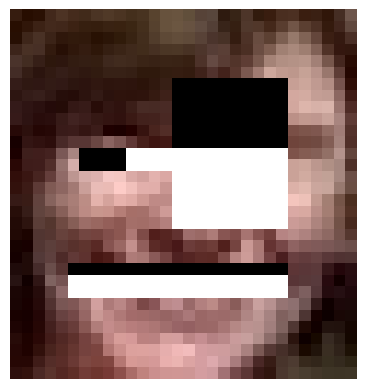

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import random 


def generate_2_rect_features(window_size):
    width, height = window_size
    features = []

   
    for w in range(2, width + 1, 2): 
        for h in range(1, height + 1):
            for x in range(0, width - w + 1):
                for y in range(0, height - h + 1):
                    features.append(('horizontal', x, y, w, h, 0))
                    features.append(('horizontal', x, y, w, h, 1))

    # Vertical features
    for w in range(1, width + 1):
        for h in range(2, height + 1, 2): 
            for x in range(0, width - w + 1):
                for y in range(0, height - h + 1):
                    features.append(('vertical', x, y, w, h, 0))
                    features.append(('vertical', x, y, w, h, 1))

    return features


window_size = (24, 24)
features = generate_2_rect_features(window_size)
print(f"Total 2-rect features: {len(features)}")


def overlay_random_features_on_face(image_path, features, num_features=3):
    image = Image.open(image_path).convert("RGB")
    draw = ImageDraw.Draw(image)

    # Randomly select 'num_features' features
    selected_features = random.sample(features, num_features)

    for feature in selected_features:
        f_type, x, y, w, h, parity = feature
        if f_type == 'horizontal' and parity == 1:
            draw.rectangle([x, y, x + w // 2, y + h], fill="white")
            draw.rectangle([x + w // 2, y, x + w, y + h], fill="black")
        elif f_type == 'horizontal' and parity == 0:
            draw.rectangle([x, y, x + w // 2, y + h], fill="black")
            draw.rectangle([x + w // 2, y, x + w, y + h], fill="white")
        elif f_type == 'vertical' and parity == 1:
            draw.rectangle([x, y, x + w, y + h // 2], fill="white")
            draw.rectangle([x, y + h // 2, x + w, y + h], fill="black")
        elif f_type == 'vertical' and parity == 0:
            draw.rectangle([x, y, x + w, y + h // 2], fill="black")
            draw.rectangle([x, y + h // 2, x + w, y + h], fill="white")
    
    return image

face_image_path = "data/tinyface/Testing_Set/Probe/21_15.jpg"

result_image = overlay_random_features_on_face(face_image_path, features)
plt.imshow(result_image)
plt.axis('off')
plt.show()


### Task 6.2: Integral Image

* Implement a function that computes the integral image of a given input image. Display the integral image for an input of you choice **(RESULT)**. 
* Compare it to the output of skimage's integral_image() function. **(RESULT)**

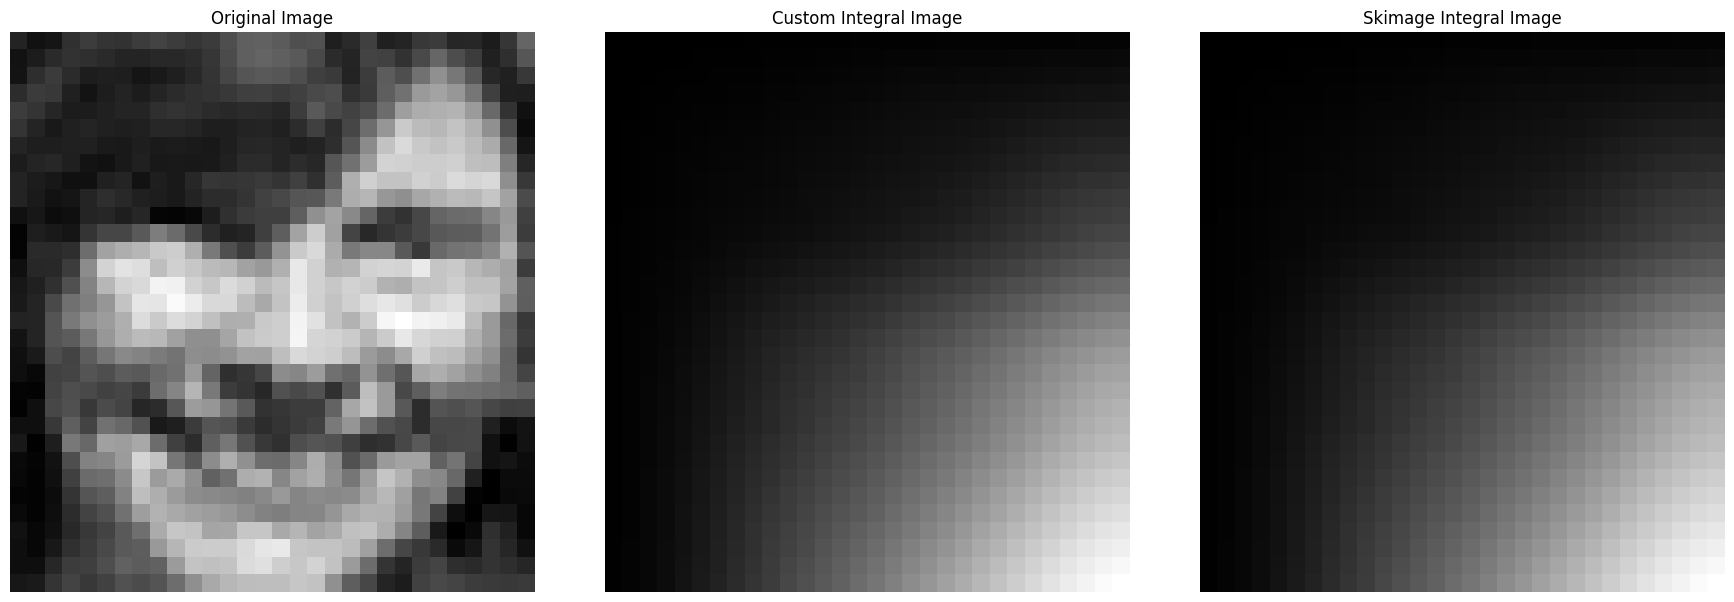

In [32]:
# code here
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from skimage.transform import integral_image

def get_integral_image(img):
    integral_img = np.zeros_like(img, dtype=np.int64)
    
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
        
            integral_img[x, y] =  (integral_img[x - 1, y] if x > 0 else 0) \
                                + (integral_img[x, y - 1] if y > 0 else 0) \
                                - (integral_img[x - 1, y - 1] if x > 0 and y > 0 else 0)\
                                + img[x, y]
    return integral_img



image= np.array(Image.open(face_image_path).convert('L'))
custom_integral_img, skimage_integral_img = get_integral_image(image), integral_image(image)


fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Display the original image
axes[0].imshow(image, cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis('off')

# Display custom integral image
axes[1].imshow(custom_integral_img, cmap='gray')
axes[1].set_title("Custom Integral Image")
axes[1].axis('off')

# Display skimage's integral image
axes[2].imshow(skimage_integral_img, cmap='gray')
axes[2].set_title("Skimage Integral Image")
axes[2].axis('off')

plt.tight_layout()
plt.show()


In [33]:
np.all(custom_integral_img==skimage_integral_img)

np.True_

### Task 6.3: AdaBoosting

* Implement the AdaBoost algorithm as outlined in the paper (https://www.face-rec.org/algorithms/Boosting-Ensemble/16981346.pdf).
* Train a 20-feature classifier using these datasets:
    - TinyFace for low resolution face images: https://qmul-tinyface.github.io/
    - CIFAR10 for negative samples: https://www.cs.toronto.edu/~kriz/cifar.html
* Test your classifier and report the results for different thresholds **(RESULTS)**

In [4]:
# #Get TinyFace using for example gdown
# !pip install gdown
# !gdown 1xTZc7lNmWN33ECO2AKH6FycGdiqIK7W0
# !unzip tinyface.zip

# TODO: Data Loading and simple preprocessing:
# Prepare (some) TinyFace samples for face data and use CIFAR10 samples for non-face data
# suggested cropping/resizing to 16x16 + grayscaling

In [7]:
# import gdown
import zipfile
import os
import numpy as np
import cv2
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from skimage import color
from skimage.io import imread
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10

In [8]:
class CustomAdaBoost:
    def __init__(self, weak_classifier, T):
        self.weak_classifier = weak_classifier
        self.T = T
        self.models = []
        self.alphas = []

    def fit(self, X, y):
        n_samples = X.shape[0]
        
        # Step 1: Initialize weights
        n_positive = np.sum(y == 1)
        n_negative = np.sum(y == 0)
        weights = np.zeros(n_samples)
        weights[y == 1] = 1 / (2 * n_positive)
        weights[y == 0] = 1 / (2 * n_negative)
        weights /= np.sum(weights)

        for t in range(self.T):
         
            model = self.weak_classifier()
            model.fit(X, y, sample_weight=weights)
            predictions = model.predict(X)
           
            weighted_error = np.sum(weights * (predictions != y))  # ∑ wi |h(xi) - yi|
           
            weighted_error = max(weighted_error, 1e-10)

            beta_t = weighted_error / (1 - weighted_error)

          
            misclassified = (predictions != y).astype(int)
            weights *= beta_t**(1 - misclassified)  
            weights /= np.sum(weights) 

          
            self.models.append(model)
            self.alphas.append(np.log(1 / beta_t))  # Alpha from β_t

    def predict(self, X):
        X = np.array(X)
        #print(X.shape)
        final_predictions = np.zeros(X.shape[0])
        for model, alpha in zip(self.models, self.alphas):
            final_predictions += alpha * (2 * model.predict(X) - 1)
        #print(final_predictions)
        return (final_predictions >= 0).astype(int)

In [9]:
def preprocess_image(image, size=(16, 16)):
    image_gray = color.rgb2gray(image)
    image_resized = cv2.resize(image_gray, size)
    return image_resized
    
def preprocess_test_image(image_path, size=(16, 16)):
    image = imread(image_path)
    image_gray = color.rgb2gray(image)
    image_resized = cv2.resize(image_gray, size)
    image_flattened = image_resized.flatten()
    return image_flattened

def load_cifar10_data():
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    y_train = y_train.flatten()
    non_face_samples = (y_train != 5) 
    #print(non_face_samples)
    x_train_non_faces = x_train[non_face_samples]
    y_train_non_faces = y_train[non_face_samples]
    return x_train_non_faces, y_train_non_faces


def extract_haar_features(image, window_size=(16, 16), max_features=20):
    def get_integral_image(image):
        return image.cumsum(axis=0).cumsum(axis=1)
    
    def sum_region(integral_img, region):
        x1, y1, x2, y2 = region
        total = integral_img[y2-1, x2-1]
        if x1 > 0:
            total -= integral_img[y2-1, x1-1]
        if y1 > 0:
            total -= integral_img[y1-1, x2-1]
        if x1 > 0 and y1 > 0:
            total += integral_img[y1-1, x1-1]
        return total

    integral_img = get_integral_image(image)
    width, height = window_size
    features = []

    # Haar-like feature definitions
    haar_windows = [
        (2, 1),  # Two horizontal
        (1, 2),  # Two vertical
        (3, 1),  # Three horizontal
        (1, 3),  # Three vertical
        (2, 2)   # Four diagonal
    ]

    for haartype, (wndx, wndy) in enumerate(haar_windows):
        for w in range(wndx, width + 1, wndx):
            for h in range(wndy, height + 1, wndy):
                for x in range(0, width - w + 1):
                    for y in range(0, height - h + 1):
                        if haartype == 0:  # Two horizontal
                            left = (x, y, x + w // 2, y + h)
                            right = (x + w // 2, y, x + w, y + h)
                            feature_value = sum_region(integral_img, left) - sum_region(integral_img, right)
                        elif haartype == 1:  # Two vertical
                            top = (x, y, x + w, y + h // 2)
                            bottom = (x, y + h // 2, x + w, y + h)
                            feature_value = sum_region(integral_img, top) - sum_region(integral_img, bottom)
                        elif haartype == 2:  # Three horizontal
                            left = (x, y, x + w // 3, y + h)
                            middle = (x + w // 3, y, x + 2 * w // 3, y + h)
                            right = (x + 2 * w // 3, y, x + w, y + h)
                            feature_value = sum_region(integral_img, left) - sum_region(integral_img, middle) + sum_region(integral_img, right)
                        elif haartype == 3:  # Three vertical
                            top = (x, y, x + w, y + h // 3)
                            middle = (x, y + h // 3, x + w, y + 2 * h // 3)
                            bottom = (x, y + 2 * h // 3, x + w, y + h)
                            feature_value = sum_region(integral_img, top) - sum_region(integral_img, middle) + sum_region(integral_img, bottom)
                        elif haartype == 4:  # Four diagonal
                            top_left = (x, y, x + w // 2, y + h // 2)
                            top_right = (x + w // 2, y, x + w, y + h // 2)
                            bottom_left = (x, y + h // 2, x + w // 2, y + h)
                            bottom_right = (x + w // 2, y + h // 2, x + w, y + h)
                            feature_value = sum_region(integral_img, top_left) - sum_region(integral_img, top_right) - sum_region(integral_img, bottom_left) + sum_region(integral_img, bottom_right)
                        else:
                            continue

                        features.append(feature_value)
                        if len(features) >= max_features:
                            return features
    return features


def prepare_data(face_data_dir, non_face_data):
    face_images = []
    face_labels = []

    training_set_dir = os.path.join(face_data_dir, 'training_set')
    for subdir, dirs, files in os.walk(training_set_dir):
        for file in files:
            if file.endswith('.jpg') or file.endswith('.png'):
                image_path = os.path.join(subdir, file)
                image = imread(image_path)
                preprocessed_image = preprocess_image(image)
                feature=extract_haar_features(preprocessed_image, window_size=(16, 16), max_features=20)
                #face_images.append(preprocessed_image)
                face_images.append(feature)
                face_labels.append(1)  # for face images
                
    face_images = np.array(face_images)
    face_labels = np.array(face_labels)

    non_face_images = []
    non_face_labels = []

    for img in non_face_data:
        preprocessed_image = preprocess_image(img)
        #print(preprocessed_image.shape)
        feature=extract_haar_features(preprocessed_image, window_size=(16, 16), max_features=20)
        #non_face_images.append(preprocessed_image)
        non_face_images.append(feature)
        non_face_labels.append(0)  # for non-face images

    non_face_images = np.array(non_face_images)
    non_face_labels = np.array(non_face_labels)

    images = np.vstack((face_images, non_face_images))
    labels = np.hstack((face_labels, non_face_labels))

    return images, labels


def train_adaboost_classifier(images, labels):
    x_train, x_valid, y_train, y_valid = train_test_split(images, labels, test_size=0.2, random_state=42)

    base_learner = lambda: DecisionTreeClassifier(max_depth=1)
    adaboost = CustomAdaBoost(weak_classifier=base_learner, T=20)

    adaboost.fit(x_train, y_train)

    y_pred = adaboost.predict(x_valid)

    accuracy = accuracy_score(y_valid, y_pred)

    return adaboost, accuracy

In [10]:
non_face_data, _ = load_cifar10_data()

face_data_dir = 'data/tinyface' 
images, labels = prepare_data(face_data_dir, non_face_data)

#x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

classifier, accuracy = train_adaboost_classifier(images, labels)
print(f"AdaBoost classifier trained with accuracy: {accuracy * 100:.2f}%")

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 0 and the array at index 1 has size 20

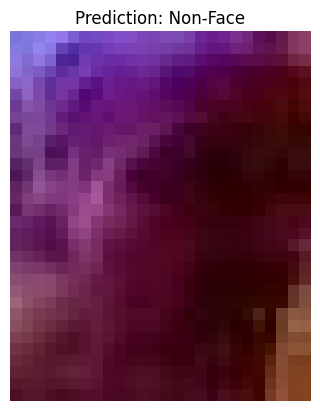

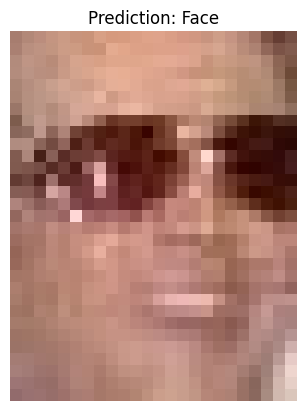

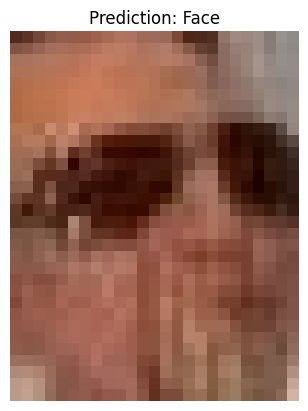

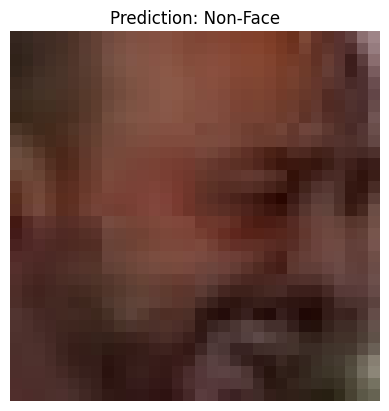

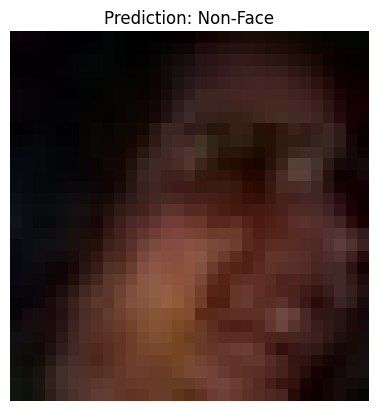

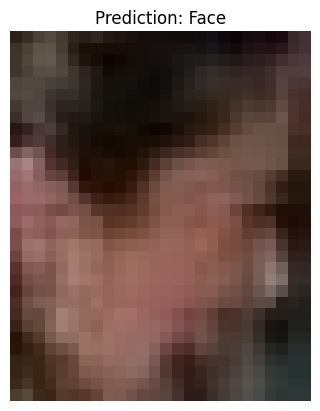

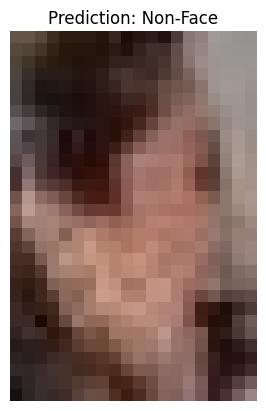

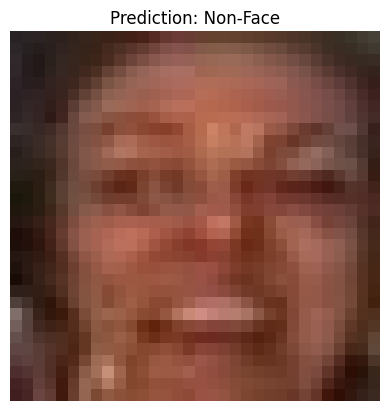

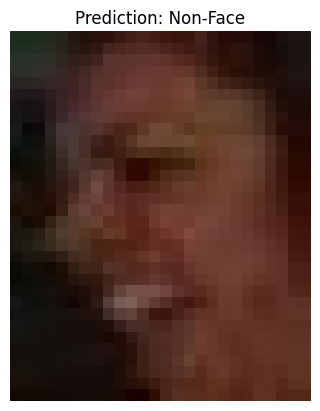

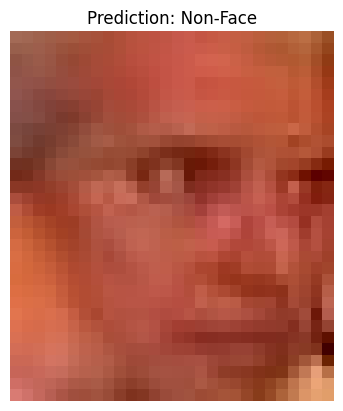

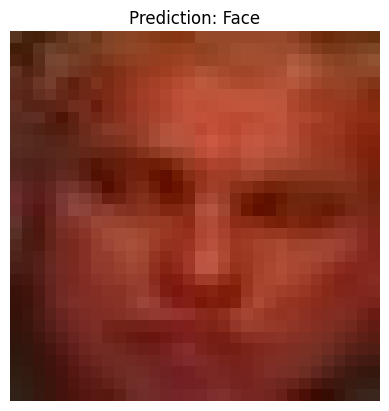

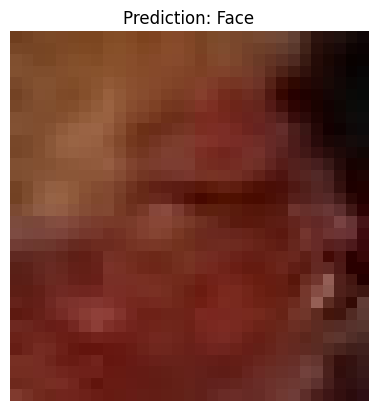

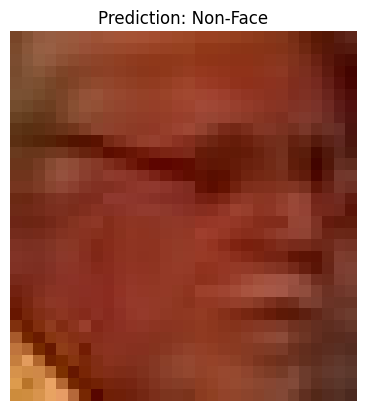

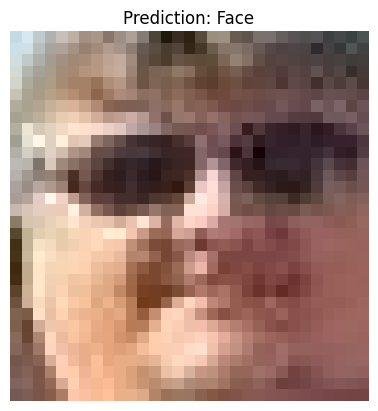

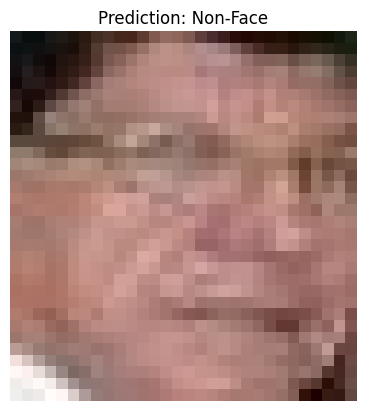

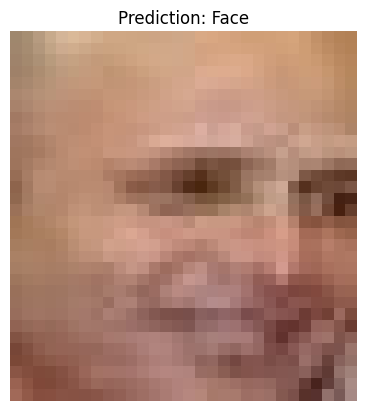

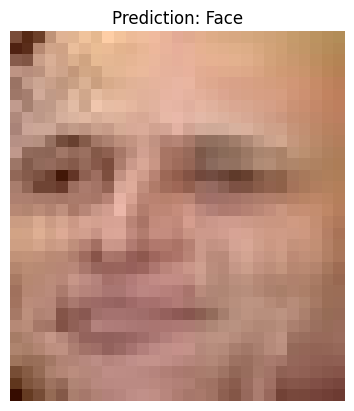

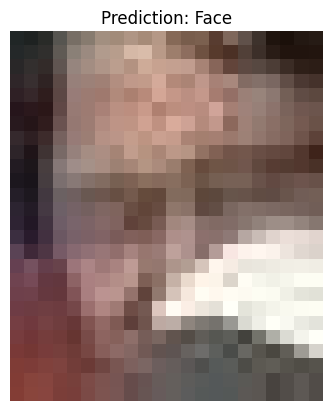

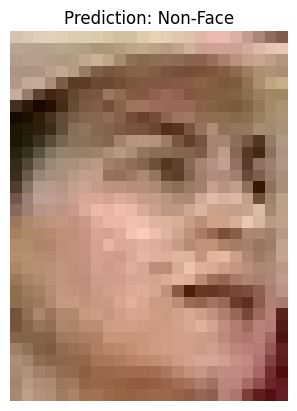

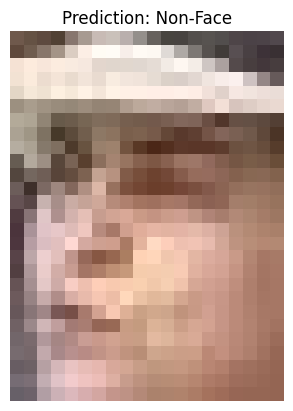

In [ ]:
def preprocess_test_image(image_path, size=(16, 16)):
    image = imread(image_path)
    image_gray = color.rgb2gray(image)
    image_resized = cv2.resize(image_gray, size)
    test_image_feature = extract_haar_features(image_resized, window_size=(16, 16), max_features=20)
    return test_image_feature

def test_and_display_images(classifier, test_images_dir):
    image_paths = [os.path.join(test_images_dir, file) for file in os.listdir(test_images_dir) if file.endswith('.jpg') or file.endswith('.png')][0:20]
    
    for image_path in image_paths:
        image_feature = preprocess_test_image(image_path)
        prediction = classifier.predict([image_feature])

        image = imread(image_path)
        plt.imshow(image)
        plt.title(f"Prediction: {'Face' if prediction == 1 else 'Non-Face'}")
        plt.axis('off') 
        plt.show()


test_face_image_dir = 'data/tinyface/Testing_Set/Probe/'  # Replace with the actual path
test_and_display_images(classifier, test_face_image_dir)


In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

def test_adaboost_classifier(classifier, x_test, y_test, thresholds=None):
    if thresholds is None:
        thresholds = np.linspace(0, 1, 11)
    
    continuous_predictions = np.zeros(x_test.shape[0])
    for model, alpha in zip(classifier.models, classifier.alphas):
        continuous_predictions += alpha * (2 * model.predict(x_test) - 1)
    
    # Initialize lists to store results for each threshold
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    auc_scores = []
    
    for threshold in thresholds:
        binary_predictions = (continuous_predictions >= threshold).astype(int)

   
        accuracy = accuracy_score(y_test, binary_predictions)
        precision = precision_score(y_test, binary_predictions)
        recall = recall_score(y_test, binary_predictions)
        f1 = f1_score(y_test, binary_predictions)
        auc = roc_auc_score(y_test, continuous_predictions)

        # Append the results for this threshold
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
        auc_scores.append(auc)
    

    results = {
        "Threshold": thresholds,
        "Accuracy": accuracies,
        "Precision": precisions,
        "Recall": recalls,
        "F1 Score": f1_scores,
        "AUC": auc_scores
    }

    for i, threshold in enumerate(thresholds):
        print(f"Threshold: {threshold:.2f}")
        print(f"  Accuracy: {accuracies[i]*100:.2f}%")
        print(f"  Precision: {precisions[i]:.2f}")
        print(f"  Recall: {recalls[i]:.2f}")
        print(f"  F1 Score: {f1_scores[i]:.2f}")
        print(f"  AUC: {auc_scores[i]:.2f}")
        print("-" * 40)
    
    return results

x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
results = test_adaboost_classifier(classifier, x_test, y_test)


Threshold: 0.00
  Accuracy: 73.42%
  Precision: 0.33
  Recall: 0.69
  F1 Score: 0.44
  AUC: 0.80
----------------------------------------
Threshold: 0.10
  Accuracy: 75.04%
  Precision: 0.34
  Recall: 0.67
  F1 Score: 0.45
  AUC: 0.80
----------------------------------------
Threshold: 0.20
  Accuracy: 76.74%
  Precision: 0.36
  Recall: 0.65
  F1 Score: 0.46
  AUC: 0.80
----------------------------------------
Threshold: 0.30
  Accuracy: 78.35%
  Precision: 0.38
  Recall: 0.63
  F1 Score: 0.47
  AUC: 0.80
----------------------------------------
Threshold: 0.40
  Accuracy: 79.56%
  Precision: 0.39
  Recall: 0.62
  F1 Score: 0.48
  AUC: 0.80
----------------------------------------
Threshold: 0.50
  Accuracy: 80.79%
  Precision: 0.41
  Recall: 0.60
  F1 Score: 0.49
  AUC: 0.80
----------------------------------------
Threshold: 0.60
  Accuracy: 81.82%
  Precision: 0.43
  Recall: 0.57
  F1 Score: 0.49
  AUC: 0.80
----------------------------------------
Threshold: 0.70
  Accuracy: 82.50%

## Congratz, you made it! :)